## AMAZON REVIEWS SENTIMENT ANALYSIS

#### Project Objective:
* Exploring VADER (Valence Aware Dictionary and sEntiment Reasoner) and RoBERTa (Robustly Optimized BERT) sentiment analysis techniques.
* Comparing  these two techniques, and understanding when/where they are suitable. 


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

In [103]:

# import and read the data
df = pd.read_csv("C:\\Users\\14257\\OneDrive\\Desktop\\Github Projects\\NLP projects\\archive (8)\\Reviews.csv")

In [104]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [105]:
# Check the data shape
df.shape

(568454, 10)

In [106]:
data = df.iloc[:5000]  # Takes the first 5000 rows sequentially
print(data.shape)

(5000, 10)


Text(0.5, 0, 'Review Stars')

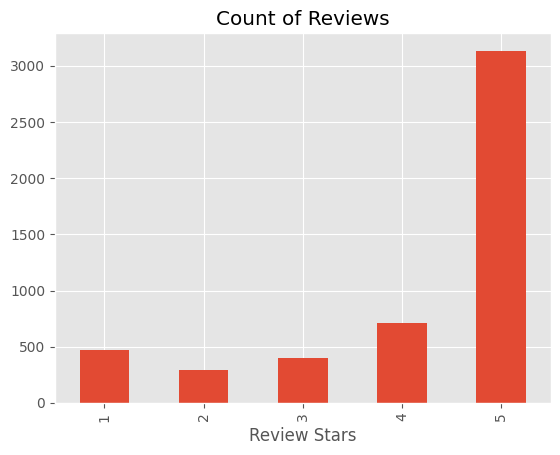

In [107]:
ax= data['Score'].value_counts().sort_index()\
.plot(kind='bar', title="Count of Reviews", fig=(10,5))
ax.set_xlabel('Review Stars')


### 1. Sentiment Aanlysis using VADER (Valence Aware Dictionary and sEntiment Reasoner)

* This approach automatically tokenizes text into words, punctuation marks, emoticons, and special symbols.
* VADER accepts raw text, perfoms tokenization in the background and computes positive,negative, neatral and compound scores for each token.
* This approach does not account for relationship between words. It essentially looks at each word and scores it individually. This is a challenge because, naturally, human language do not work like that.


In [108]:
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm # Progress tracker 

In [109]:
sia = SentimentIntensityAnalyzer() # Initialize the sentiment analyzer

In [110]:
# VADER scoring Example
sia.polarity_scores('I am so Happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

* The text has no negative sentiment.
* 33.4% of the text conveys a neutral tone
* 66.6% of the text conveys a positive sentiment

In [111]:
sia.polarity_scores('This product is bad')

{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}

* The text has no positive sentiment.
* 46.2% of the text conveys a neutral tone
* 53.8% of the text conveys a positive sentiment

In [112]:
# Running VADER polarity score on the text column of the dataset
results = {}
for i, row in data.iterrows():
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)


In [113]:
# change the vaders scores into a dataframe
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
# Merge the scores to the original dataset 
vaders = vaders.merge(data,how='left')

In [114]:
# Original dataset with VADERS score for each column
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


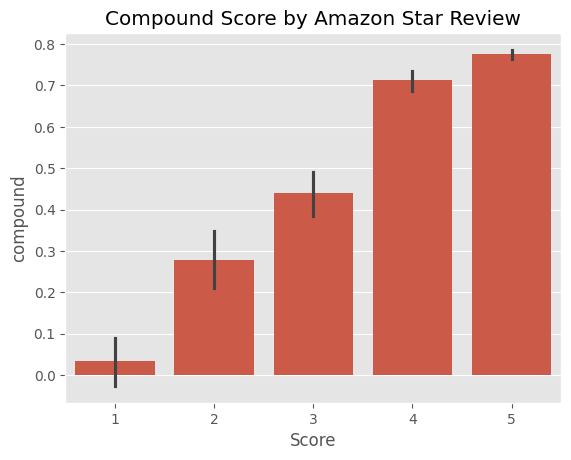

In [115]:
# Compare the VADER compound results to the amazon star reviews score
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

* As the Amazon star review score increases, the compound score also increases. This indicates that higher star reviews tend to have more positive sentiments based on VADER analysis
* 4 Stars and 5 Stars show the highest compound scores, indicating very positive sentiment. The 5-star reviews, in particular, have the highest positivity.

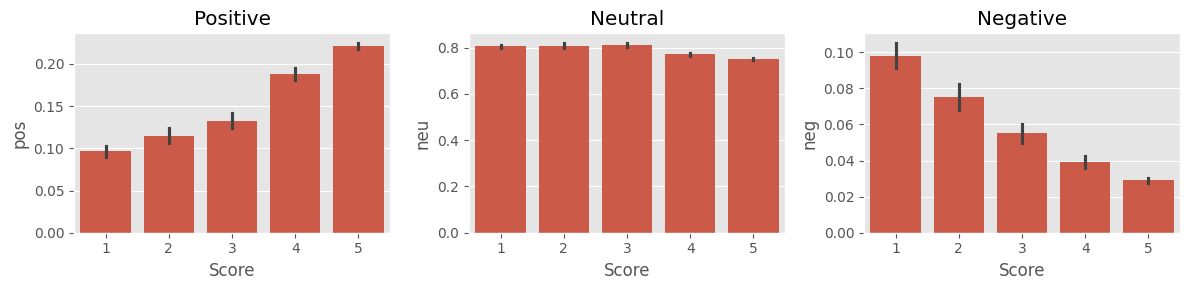

In [116]:
# Compare the VADER positive, negative and neutral results to the amazon star reviews score separately.
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()


* Low ratings (1 and 2): Dominated by negative sentiment with some neutral elements.
* Mid-range ratings (3): Balanced between positive, neutral, and negative sentiment.
* High ratings (4 and 5): Strongly positive sentiment with minimal neutral or negative sentiment.

* Sentiment Validation: This breakdown could be used to validate customer review models where sentiment needs to align with star ratings.
* Review Analysis: Understanding the mix of sentiment in specific star categories can help companies identify areas of dissatisfaction or improvement.
* Anomaly Detection: Reviews with mismatched sentiment scores and star ratings (e.g., high positive sentiment in a 1-star review) can be flagged for further investigation.

### 2. RoBERTa Pretrained Model

* RoBERTa is different from VADER in that it considers the entire context of a word (both before and after it) to better understand its meaning.
* It is pretrained on large amount of unlabeled texts using masked language modeling. This means it masks random words in the input and trains the model to predict masked tokens based on the context. 

In [117]:
from transformers import AutoTokenizer # This converts the text into token IDs that the model can understand. 
from transformers import AutoModelForSequenceClassification, pipeline # pretrained model for sequence classification
from scipy.special import softmax # converts raw logits into probabilities.

In [118]:
# Specifying the model: This is a pretrained model specifically for sentiment analysis on twitter data.
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
# Load tokenizer and model from Hugging Face's transformers library

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL) # This is a pretrained model specific for sequence classification tasks


In [120]:
## Run RoBERTa Model on one sentence as an example

text = data['Text'][50]
text

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [121]:
encoded_text = tokenizer(text, return_tensors='pt') # The tokenizer will convert the words into token and map them to token IDs
output = model(**encoded_text) # run the roberta model on encoded text example and get output logits
scores = output[0][0].detach().numpy() 
scores = softmax(scores) # Convert logits into probabilities
scores= {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

scores = {key: float(value) for key, value in scores.items()}
print(scores)

{'roberta_neg': 0.9763551354408264, 'roberta_neu': 0.020687466487288475, 'roberta_pos': 0.002957369200885296}


In [122]:
# Running roBERTa Model on the entire Text Column

## Define the roberta model function
def scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt') # The tokenizer will convert the words into token and map them to token IDs
    output = model(**encoded_text) # run the roberta model on encoded text example and get output logits
    scores = output[0][0].detach().numpy() 
    scores = softmax(scores) # Convert logits into probabilities
    scores= {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    scores = {key: float(value) for key, value in scores.items()}
    return scores
    


In [123]:
results = {}
for i, row in data.iterrows():
    try:
        text = row['Text']
        myid = row['Id']
        vader_results= sia.polarity_scores(text)
        vader_results_renamed = {}
        for Key, value in vader_results.items():
            vader_results_renamed[f"vader_{Key}"]=value    
        roberta_results= scores_roberta(text)
        both_models_scores = {**vader_results_renamed, **roberta_results}
        results[myid]=both_models_scores
    except RuntimeError: 
        print(f'Error at {myid}')
    


Error at 83
Error at 187
Error at 529
Error at 540
Error at 746
Error at 863
Error at 1053
Error at 1070
Error at 1156
Error at 1321
Error at 1375
Error at 1498
Error at 1575
Error at 1796
Error at 1826
Error at 2169
Error at 2248
Error at 2476
Error at 2492
Error at 2584
Error at 2610
Error at 2897
Error at 2898
Error at 2902
Error at 2928
Error at 2942
Error at 2944
Error at 2947
Error at 2948
Error at 3022
Error at 3023
Error at 3025
Error at 3306
Error at 3788
Error at 3969
Error at 4107
Error at 4110
Error at 4307
Error at 4316
Error at 4408
Error at 4483
Error at 4512
Error at 4553
Error at 4583


In [124]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(data,how='left')

In [125]:
results_df.head() 

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 3. Comparing the scores for both models

In [126]:
results = pd.DataFrame(results)
results 

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
vader_neg,0.000000,0.138000,0.091000,0.000000,0.000000,0.029000,0.034000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.115000,0.000000,0.080000,0.025000,0.026000,0.097000,0.154000,0.000000
vader_neu,0.695000,0.862000,0.754000,1.000000,0.552000,0.809000,0.693000,0.520000,0.851000,0.705000,...,0.565000,0.818000,0.848000,0.679000,0.692000,0.883000,0.764000,0.827000,0.637000,0.717000
vader_pos,0.305000,0.000000,0.155000,0.000000,0.448000,0.163000,0.273000,0.480000,0.149000,0.295000,...,0.435000,0.182000,0.037000,0.321000,0.228000,0.092000,0.210000,0.076000,0.209000,0.283000
vader_compound,0.944100,-0.566400,0.826500,0.000000,0.946800,0.883000,0.934600,0.948700,0.636900,0.831300,...,0.953100,0.717700,-0.826400,0.969300,0.792000,0.719300,0.984600,-0.055400,0.907800,0.992300
roberta_neg,0.009624,0.508986,0.003229,0.002295,0.001635,0.006130,0.001305,0.002029,0.003874,0.003103,...,0.001691,0.007842,0.905936,0.001312,0.133682,0.100337,0.019922,0.602979,0.011522,0.009068
roberta_neu,0.049980,0.452414,0.098067,0.090219,0.010302,0.021796,0.007774,0.005685,0.094156,0.055912,...,0.009245,0.126614,0.084066,0.007160,0.375455,0.300059,0.092043,0.333857,0.044735,0.052034
roberta_pos,0.940395,0.038600,0.898704,0.907486,0.988063,0.972075,0.990921,0.992285,0.901970,0.940984,...,0.989064,0.865544,0.009998,0.991528,0.490863,0.599604,0.888035,0.063164,0.943743,0.938897


In [127]:
def classify_sentiment(negative, neutral, positive):
    if max(negative, neutral, positive) == negative:
        return 'negative'
    elif max(negative, neutral, positive) == neutral:
        return 'neutral'
    else:
        return 'positive'


In [128]:
results_df['vader_sentiment'] = results_df.apply(lambda row: classify_sentiment(row['vader_neg'], row['vader_neu'], row['vader_pos']), axis=1)
results_df['roberta_sentiment'] = results_df.apply(lambda row: classify_sentiment(row['roberta_neg'], row['roberta_neu'], row['roberta_pos']), axis=1)


In [130]:
# A function to map VADER compound scores to sentiment using commonly used thresholds
### Negative Sentiment (compound ≤ -0.05)
### Neutral Sentiment (-0.05 < compound < 0.05
### Positive Sentiment (compound ≥ 0.05)

def map_vader_compound_to_sentiment(compound):
    if compound <= -0.05:
        return 'negative'
    elif -0.05 < compound < 0.05:
        return 'neutral'
    else:
        return 'positive'

results_df['vader_sentiment_from_compound'] = results_df['vader_compound'].apply(map_vader_compound_to_sentiment)

# A function to map original customer ratings to sentiment
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'
results_df['customer_sentiment'] = results_df['Score'].apply(map_rating_to_sentiment)

# agreement between VADER (based on compound score) and customer sentiment
results_df['vader_agreement'] = results_df['vader_sentiment_from_compound'] == results_df['customer_sentiment']

# agreement between RoBERTa and customer sentiment
results_df['roberta_agreement'] = results_df['roberta_sentiment'] == results_df['customer_sentiment']

# % Agreement 
vader_agreement_percent = results_df['vader_agreement'].mean() * 100
roberta_agreement_percent = results_df['roberta_agreement'].mean() * 100

print(f"VADER agreement with customer rating (Score): {vader_agreement_percent:.2f}%")
print(f"RoBERTa agreement with customer rating (Score): {roberta_agreement_percent:.2f}%")


VADER agreement with customer rating (Score): 79.76%
RoBERTa agreement with customer rating (Score): 85.21%


### Conclusion:
* VADER shows 79.76% agreement, performing reasonably well but struggling with ~20% of cases due to its lexicon-based approach, which may misinterpret nuances, sarcasm, or domain-specific expressions. 
* RoBERTa achieves 85.21% agreement, leveraging its deep learning architecture for better contextual understanding, though ~15% disagreement highlights challenges with ambiguous or subjective inputs.

* RoBERTa’s superior accuracy makes it ideal for tasks requiring nuanced understanding, while VADER’s speed and simplicity suit resource-constrained applications. Investigating disagreement patterns can uncover areas for improvement, such as handling sarcasm or tailoring VADER for domain-specific needs.
